In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from random import uniform
%matplotlib inline

In [2]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 1)
        )
    def forward(self,x):
        x=self.net(x)
        return x

In [3]:
def u_function(x, t):
    u = model(torch.hstack((x, t)))
    return u

def f_function(x, t, nu):
    u = u_function(x, t)
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
    return u_t + u * u_x - nu * u_xx

def Loss(u, x_u, t_u, x_f, t_f, nu):
    u_pre = u_function(x_u, t_u)
    f_pre = f_function(x_f, t_f, nu)
    # loss
    null =  torch.zeros((x_f.shape[0], 1))
    u_loss = loss_fn(u_pre, u)
    f_loss = loss_fn(f_pre, null)
    ls = u_loss + f_loss
    ls.backward()
    return ls


In [4]:
# 制造数据点集，要求区分边界点X_u_train和内点X_f_train
nu = 0.01 / np.pi
N_u = 100
N_f = 10000

# 边界点X_u_train
x_upper = np.ones((N_u//4, 1), dtype=float)
x_lower = np.ones((N_u//4, 1), dtype=float) * (-1)
t_zero = np.zeros((N_u//2, 1), dtype=float)

t_upper = np.random.rand(N_u//4, 1)
t_lower = np.random.rand(N_u//4, 1)
x_zero = np.random.rand(N_u//2, 1) * (1 - (-1)) -1 # 从0，1映射到-1，1

X_upper = np.hstack((x_upper, t_upper)) # 按列拼接
X_lower = np.hstack((x_lower, t_lower))
X_zero = np.hstack((x_zero, t_zero))

X_u_train = np.vstack((X_upper, X_lower, X_zero)) # 按行拼接
index = np.arange(0, N_u)
np.random.shuffle(index)
X_u_train = X_u_train[index, :] # 打乱训练集

# 内点X_f_train
X_f_train = np.zeros((N_f, 2), dtype=float)
for row in range(N_f):
    x = uniform(-1, 1)
    t = uniform( 0, 1)
    X_f_train[row, 0] = x 
    X_f_train[row, 1] = t
X_f_train = np.vstack((X_f_train, X_u_train))

# 边界条件u_train
u_upper =  np.zeros((N_u//4, 1), dtype=float)
u_lower =  np.zeros((N_u//4, 1), dtype=float) 
u_zero = -np.sin(np.pi * x_zero)  

u_train = np.vstack((u_upper, u_lower, u_zero))

u_train = u_train[index, :] # 对应X_u_train顺序

In [5]:
# 模型训练
model=MLP()
loss_fn = nn.MSELoss()  #均方差做损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

x_u = torch.tensor(X_u_train[:, 0].reshape(-1, 1), dtype=torch.float32, requires_grad=True)
t_u = torch.tensor(X_u_train[:, 1].reshape(-1, 1), dtype=torch.float32, requires_grad=True)

x_f = torch.tensor(X_f_train[:, 0].reshape(-1, 1), dtype=torch.float32, requires_grad=True)
t_f = torch.tensor(X_f_train[:, 1].reshape(-1, 1), dtype=torch.float32, requires_grad=True)

u = torch.tensor(u_train, dtype=torch.float32)

epochs = 2000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = Loss(u, x_u, t_u, x_f, t_f, nu)
    if epoch % 100 ==0:
        print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}]")
    optimizer.step()


[Epoch 1/2000] [loss: 0.2884927988052368]
[Epoch 101/2000] [loss: 0.07473829388618469]
[Epoch 201/2000] [loss: 0.05876632779836655]
[Epoch 301/2000] [loss: 0.03463907167315483]
[Epoch 401/2000] [loss: 0.027871403843164444]
[Epoch 501/2000] [loss: 0.03400927037000656]
[Epoch 601/2000] [loss: 0.013547694310545921]
[Epoch 701/2000] [loss: 0.014740385115146637]
[Epoch 801/2000] [loss: 0.008138282224535942]
[Epoch 901/2000] [loss: 0.003756712656468153]
[Epoch 1001/2000] [loss: 0.25963592529296875]
[Epoch 1101/2000] [loss: 0.10064652562141418]
[Epoch 1201/2000] [loss: 0.06593876332044601]
[Epoch 1301/2000] [loss: 0.05646662041544914]
[Epoch 1401/2000] [loss: 0.04701795428991318]
[Epoch 1501/2000] [loss: 0.04237569123506546]
[Epoch 1601/2000] [loss: 0.0378052294254303]
[Epoch 1701/2000] [loss: 0.07181081920862198]
[Epoch 1801/2000] [loss: 0.103150874376297]
[Epoch 1901/2000] [loss: 0.08382997661828995]


E:\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


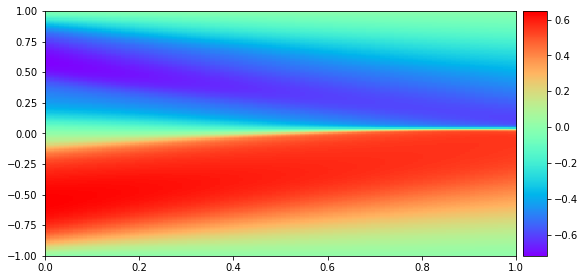

In [6]:
# 可视化
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
x = torch.linspace(-1, 1, 200, dtype=torch.float32)
t = torch.linspace( 0, 1, 100, dtype=torch.float32)
X, T = torch.meshgrid(x, t)
xcol = X.reshape(-1, 1)
tcol = T.reshape(-1, 1)
u_pre = u_function(xcol, tcol).reshape(x.numel(), t.numel())
xnp = x.numpy()
tnp = t.numpy()
Unp = u_pre.detach().numpy()
# plot:
fig = plt.figure(figsize=(9, 4.5))
ax = fig.add_subplot(111)

h = ax.imshow(Unp,
              interpolation='nearest',
              cmap='rainbow', 
              extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax) # 新建一个坐标轴，右侧
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=10)
plt.show()

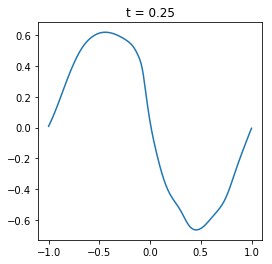

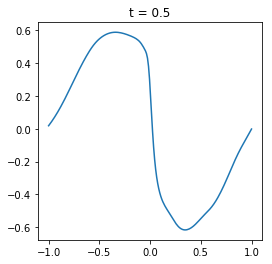

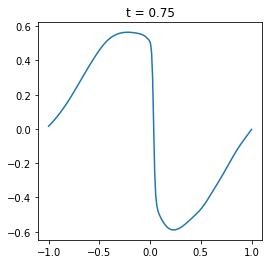

In [7]:
def plot_t(m):
    x = torch.linspace(-1, 1, 200, dtype=torch.float32)
    t = torch.full_like(x, m, dtype=torch.float32)
    X, T = torch.meshgrid(x, t)
    xcol = X.reshape(-1, 1)
    tcol = T.reshape(-1, 1)
    u_pre = u_function(xcol, tcol).detach().numpy().reshape(-1, 1)
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.plot(xcol,u_pre)
    title = 't = ' + str(m)
    plt.title(title)
    plt.show()
plot_t(0.25)
plot_t(0.5)
plot_t(0.75)

In [8]:
0.01 / np.pi

0.003183098861837907